<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intuition-for-the-divergence" data-toc-modified-id="Intuition-for-the-divergence-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intuition for the divergence</a></span></li><li><span><a href="#Recognizing-Decision-Stumps" data-toc-modified-id="Recognizing-Decision-Stumps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recognizing Decision Stumps</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Binary-vs.-OvA" data-toc-modified-id="Binary-vs.-OvA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Binary vs. OvA</a></span></li><li><span><a href="#Problems" data-toc-modified-id="Problems-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Problems</a></span><ul class="toc-item"><li><span><a href="#Outliers-make-bins-too-coarse" data-toc-modified-id="Outliers-make-bins-too-coarse-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Outliers make bins too coarse</a></span></li><li><span><a href="#Bins-chosen-too-fine" data-toc-modified-id="Bins-chosen-too-fine-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Bins chosen too fine</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_blobs
%matplotlib inline
import sys
sys.path.append('/home/nam/Desktop')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext watermark
%watermark -t -m -h -v --iversions

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 4.15.0-128-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Hostname: ski-lab

numpy     : 1.19.4
sklearn   : 0.24.0
matplotlib: 3.3.1
sys       : 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]



# Intuition for the divergence

In [4]:
p = np.array([0,1,1,1,0]) + 1.0e-12 # eps to avoid divide by 0 in KL
q = np.array([1,0,1,0,1]) + 1.0e-12

norm_p = p / np.sum(p)
norm_q = q / np.sum(q)
m = norm_p + norm_q

def kl_div(a,b):
    return np.sum(a*np.log2(a/b))
    
def js_div(a,b):
    m = 0.5*(a+b)
    return 0.5*kl_div(a,m) + 0.5*kl_div(b,m)

js_div(norm_p, norm_q) # 2/3 "different"

0.6666666666393517

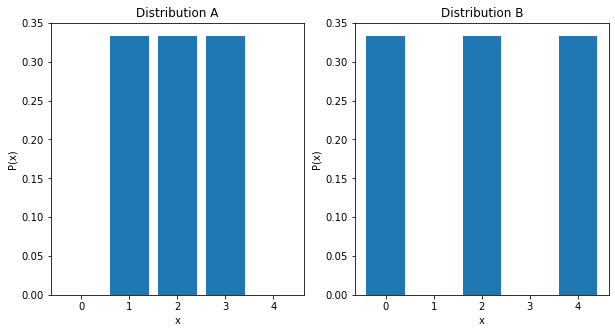

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].bar(height=norm_p, x=[0,1,2,3,4], alpha=1)
axes[0].set_title('Distribution A')
axes[0].set_xlabel('x')
axes[0].set_ylabel('P(x)')

axes[1].bar(height=norm_q, x=[0,1,2,3,4], alpha=1)
axes[1].set_title('Distribution B')
axes[1].set_xlabel('x')
axes[1].set_ylabel('P(x)')

fig.patch.set_facecolor('white')
# plt.savefig('js_example2.png', dpi=300, transparent=False)

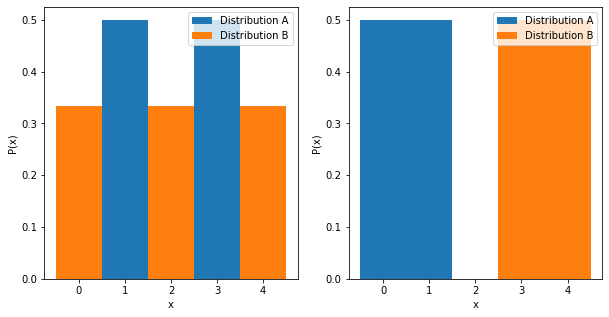

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist([1,1,3,3], bins=5, align='left', range=(0,5), label='Distribution A', density=True)
axes[0].hist([0,2,4], bins=5, align='left', range=(0,5), label='Distribution B', density=True)
axes[0].set_xlabel('x')
axes[0].set_ylabel('P(x)')
axes[0].legend(loc='best')

axes[1].hist([1,1,0,0], bins=5, align='left', range=(0,5), label='Distribution A', density=True)
axes[1].hist([3,4], bins=5, align='left', range=(0,5), label='Distribution B', density=True)
axes[1].set_xlabel('x')
axes[1].set_ylabel('P(x)')
axes[1].legend(loc='best')

fig.patch.set_facecolor('white')
# plt.savefig('js_example1.png', dpi=300, transparent=False)

# Recognizing Decision Stumps

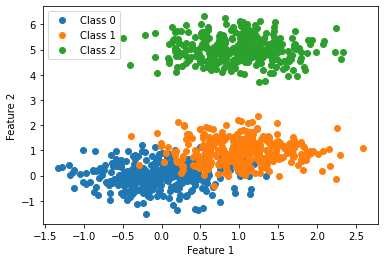

In [7]:
X, y = sklearn.datasets.make_blobs(n_samples=1000, 
                            n_features=2, 
                            centers=[[0,0],[1,1],[1,5]], 
                            cluster_std=.5,  
                            shuffle=True, 
                            random_state=0)

fig = plt.figure()
for i in range(3):
    mask = y == i
    plt.plot(X[mask,0], X[mask,1], 'o', color='C{}'.format(i), label='Class {}'.format(i))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')

fig.patch.set_facecolor('white')
# plt.savefig('js_example3.png', dpi=300, transparent=False)

In [8]:
from ml_utils.sklearn_ext.feature_selection import JensenShannonDivergence as JS
js = JS(top_k=1, per_class=False, bins=25, feature_names=['Feature 1', 'Feature 2'], threshold=0.7)
_ = js.fit(X, y)

In [9]:
js.divergence # Feature B easily divides class 2 from 0 and 1

[('Feature 2',
  {0: 0.6553292334630374, 1: 0.656979501313671, 2: 0.9999999999987976}),
 ('Feature 1',
  {0: 0.5354697215862734, 1: 0.19447451048948608, 2: 0.16221856693750952})]

/home/nam/Desktop/ml_utils/sklearn_ext/feature_selection.py:356: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax_.set_xticklabels(xv, rotation=90)


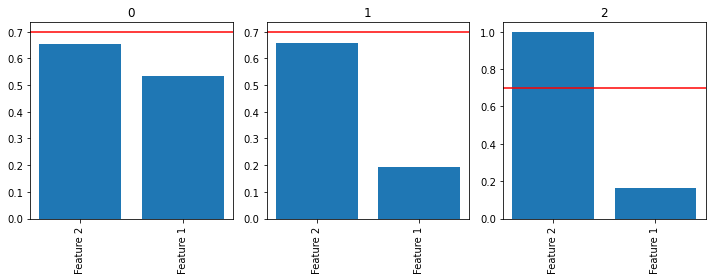

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
js.visualize(by_class=True, threshold=0.7, ax=ax)

fig.patch.set_facecolor('white')
# plt.savefig('js_example4.png', dpi=300, transparent=False)

In [11]:
js.accepted

array(['Feature 2'], dtype='<U9')

# Clustering

In [12]:
np.random.seed(0)

# Split up feature 1
A = np.random.normal(loc=1, scale=0.3, size=100)
B = np.random.normal(loc=2, scale=0.2, size=100)
C = np.random.normal(loc=2, scale=0.2, size=100)
D = np.random.normal(loc=1.5, scale=1, size=100)

# Feature 2 is sampled from the same random, normal distribution
F2 = np.random.normal(loc=1, scale=1, size=400)

X = np.hstack((np.concatenate([A, B, C, D]).reshape(-1,1), F2.reshape(-1,1)))
y = np.array(["A"]*len(A) + ["B"]*len(B) + ["C"]*len(C) + ["D"]*len(D), dtype=object)
ranges = (np.min(X[:,0]), np.max(X[:,0]))

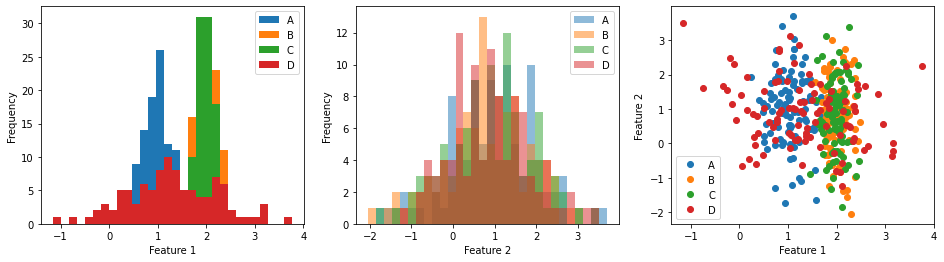

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

axes[0].hist(A, label='A', bins=30, range=ranges)
axes[0].hist(B, label='B', bins=30, range=ranges)
axes[0].hist(C, label='C', bins=30, range=ranges)
axes[0].hist(D, label='D', bins=30, range=ranges)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')

for c in ['A', 'B', 'C', 'D']:
    mask = y == c
    axes[1].hist(F2[mask], label=c, bins=30, range=(np.min(F2), np.max(F2)), alpha=0.5)
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Frequency')
axes[1].legend(loc='best')

for c in ['A', 'B', 'C', 'D']:
    mask = y == c
    axes[2].plot(X[mask,0], X[mask,1], label=c, marker='o', lw=0)
axes[2].legend(loc='best')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

fig.patch.set_facecolor('white')
# plt.savefig('js_example5.png', dpi=300, transparent=False)

In [14]:
from ml_utils.eda.screen import JSScreen as JSC

In [15]:
jsc = JSC(n=3, feature_names=['Feature 1', 'Feature 2'], js_bins=25)
_ = jsc.fit(X, y)

100%|██████████| 4/4 [00:00<00:00, 205.72it/s]

100%|██████████| 6/6 [00:00<00:00, 281.66it/s]

100%|██████████| 3/3 [00:00<00:00, 51.29it/s]


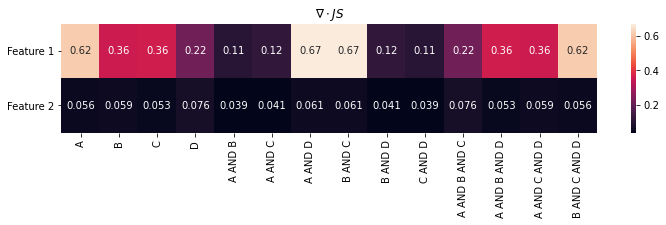

In [16]:
fig = plt.figure(figsize=(12,2))
jsc.visualize_grid(fig.gca())

fig.patch.set_facecolor('white')
# plt.savefig('js_example6.png', dpi=300, transparent=False, bbox_inches='tight')

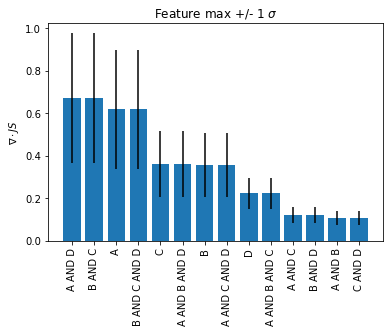

In [17]:
fig = plt.figure()
fig.patch.set_facecolor('white')
_ = jsc.visualize_classes(method='max', ax=fig.gca())
# plt.savefig('js_example7.png', dpi=300, transparent=False, bbox_inches='tight')

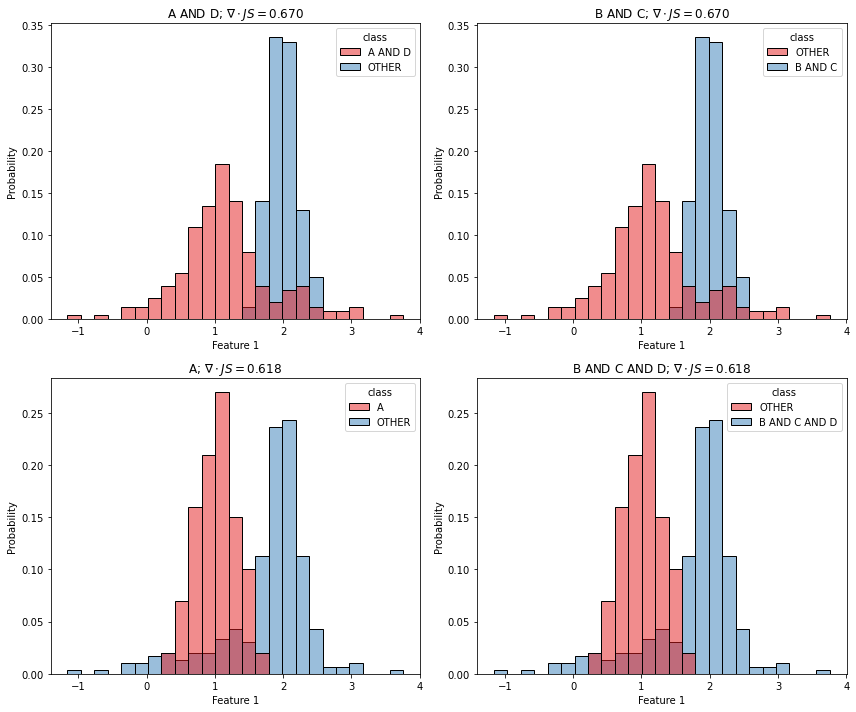

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.patch.set_facecolor('white')
_ = jsc.visualize_max(top=4, bins=25, ax=axes.ravel())
plt.tight_layout()
# plt.savefig('js_example8.png', dpi=300, transparent=False, bbox_inches='tight')

In [19]:
jsc.interesting(threshold=0.65, method="max", min_delta=0.05)

[(('D', 'A'),
  {'delta': 0.44729036478714307,
   'final': 0.6703982112644471,
   'individuals': {'A': 0.6179705079270768, 'D': 0.22310784647730403}}),
 (('B', 'C'),
  {'delta': 0.3143482627438243,
   'final': 0.6703982112644471,
   'individuals': {'C': 0.3620002915718423, 'B': 0.35604994852062277}}),
 (('C', 'B'),
  {'delta': 0.30839791969260477,
   'final': 0.6703982112644471,
   'individuals': {'C': 0.3620002915718423, 'B': 0.35604994852062277}}),
 (('A', 'D'),
  {'delta': 0.052427703337370346,
   'final': 0.6703982112644471,
   'individuals': {'A': 0.6179705079270768, 'D': 0.22310784647730403}})]

In [20]:
# (B,C) separted from the (A,D)
# This is not always symmetric like this!

# Binary vs. OvA

In [21]:
from ml_utils.eda.screen import JSBinary

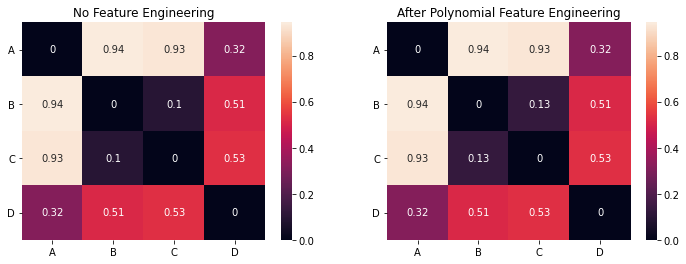

In [22]:
# Some feature engineering just to test
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ss = SS()
X_std = ss.fit_transform(X)

jsb = JSBinary(js_bins=25)
_ = jsb.fit(X_std,y)
jsb.visualize(axes[0]) # standardizing does nothing, as expected
axes[0].set_title('No Feature Engineering')

pf = PF(degree=3)
X_std_poly = pf.fit_transform(X_std)

jsb = JSBinary(js_bins=25)
_ = jsb.fit(X_std_poly,y)
jsb.visualize(axes[1]) # Only very weak improvement suggesting this is not likely to help models
axes[1].set_title('After Polynomial Feature Engineering')

fig.patch.set_facecolor('white')
plt.savefig('js_example13.png', dpi=300, transparent=False, bbox_inches='tight')

Text(0, 0.5, 'Feature 2')

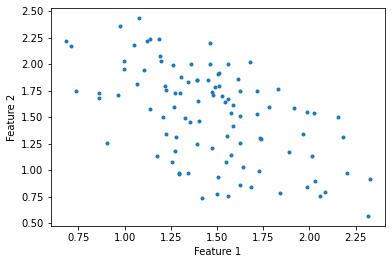

In [23]:
# Make some fake features that are anticorrelated
np.random.seed(0)
d1 = np.linspace(1,2,100)+np.random.random(100)-0.5
d2 = np.linspace(2,1,100)+np.random.random(100)-0.5

import pandas as pd
y = ['A' if a*b < 1.5 else 'B' for a,b in zip(d1,d2)]
X_dummy = pd.DataFrame(data=np.vstack((d1,d2)).T, columns=['Feature 1', 'Feature 2'])
X_dummy['class'] = y

plt.plot(d1, d2, '.')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

<Figure size 432x288 with 0 Axes>

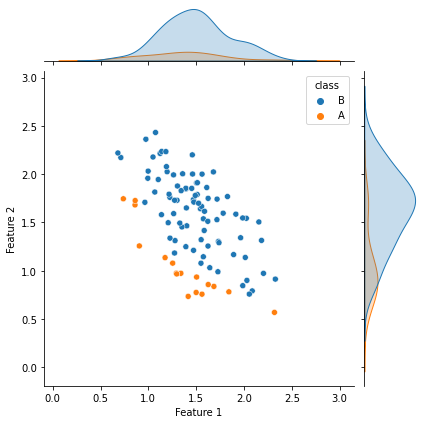

In [35]:
import seaborn as sns
fig = plt.figure()
_ = sns.jointplot(data=X_dummy, x="Feature 1", y="Feature 2", hue='class')
fig.patch.set_facecolor('white')
# plt.savefig('js_example14.png', dpi=300, transparent=False, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

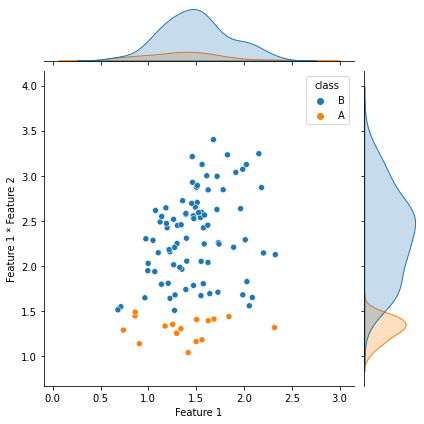

In [36]:
pf = PF(degree=2)
X_poly = pf.fit_transform(X_dummy[['Feature 1', 'Feature 2']])

fig = plt.figure()

XX = pd.DataFrame(X_poly, columns=['1', 'Feature 1', 'Feature 2', 'Feature 1^2', 'Feature 1 * Feature 2', 'Feature 2^2'])
XX['class'] = y
sns.jointplot(data=XX, x="Feature 1", y='Feature 1 * Feature 2', hue='class')

fig.patch.set_facecolor('white')
plt.savefig('js_example15.png', dpi=300, transparent=False, bbox_inches='tight')

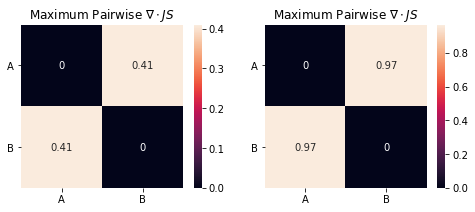

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

jsb = JSBinary(js_bins=10)
_ = jsb.fit(X_dummy[['Feature 1', 'Feature 2']], X_dummy['class'])
jsb.visualize(ax=axes[0])

jsb = JSBinary(js_bins=25)
_ = jsb.fit(X_poly,XX['class'])
jsb.visualize(ax=axes[1])

fig.patch.set_facecolor('white')
plt.savefig('js_example16.png', dpi=300, transparent=False, bbox_inches='tight')

In [29]:
jsb.top_features()

array([[None, 4],
       [4, None]], dtype=object)

# Problems

## Outliers make bins too coarse

100%|██████████| 1/1 [00:00<00:00, 206.75it/s]


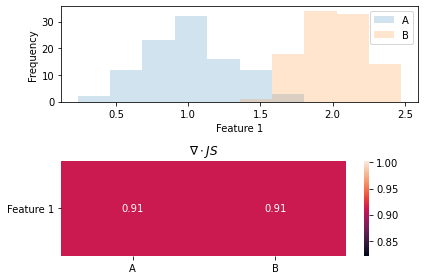

In [288]:
X = np.concatenate([A, B]).reshape(-1,1)
y = np.array(["A"]*len(A) + ["B"]*len(B), dtype=object)
ranges = (np.min(X), np.max(X))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
axes[0].hist(A, label='A', bins=10, range=ranges, alpha=0.2)
axes[0].hist(B, label='B', bins=10, range=ranges, alpha=0.2)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
fig.patch.set_facecolor('white')

jsc_no_outlier = JSC(n=1, feature_names=['Feature 1'], js_bins=10)
_ = jsc_no_outlier.fit(X, y)

jsc_no_outlier.visualize_grid(axes[1])

plt.tight_layout()
plt.savefig('js_example9.png', dpi=300, transparent=False, bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 152.70it/s]


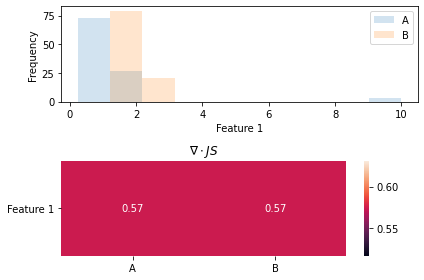

In [289]:
# Add an outlier to class A - overlap appears much higher with the same number of bins because coarser
# Specifying fixed bin width could help with this, but it is hard to know that in advance (see next issue).
# Easier to remove outliers instead.
X_out = np.concatenate((X, np.array([[10],[10],[10]]).reshape(-1,1)), axis=0)
y_out = np.concatenate((y, ['A']*3))
ranges = (np.min(X_out), np.max(X_out))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
axes[0].hist(X_out[y_out == 'A'], label='A', bins=10, range=ranges, alpha=0.2)
axes[0].hist(X_out[y_out == 'B'], label='B', bins=10, range=ranges, alpha=0.2)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
fig.patch.set_facecolor('white')

jsc_outlier = JSC(n=1, feature_names=['Feature 1'], js_bins=10)
_ = jsc_outlier.fit(X_out, y_out)
jsc_outlier.visualize_grid(axes[1])

plt.tight_layout()
plt.savefig('js_example10.png', dpi=300, transparent=False, bbox_inches='tight')

## Bins chosen too fine

In [291]:
X = np.concatenate([B, C]).reshape(-1,1)
y = np.array(["B"]*len(B) + ["C"]*len(C), dtype=object)
ranges = (np.min(X[:,0]), np.max(X[:,0]))

100%|██████████| 1/1 [00:00<00:00, 132.25it/s]


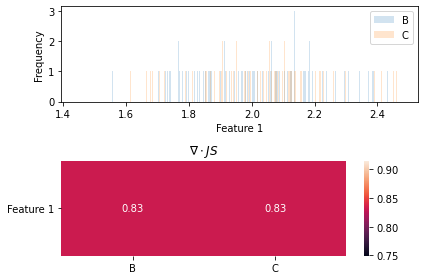

In [292]:
# Too many bins and the distributions might look like they are different
bins = 500

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
axes[0].hist(B, label='B', bins=bins, range=ranges, alpha=0.2)
axes[0].hist(C, label='C', bins=bins, range=ranges, alpha=0.2)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
fig.patch.set_facecolor('white')

jsc_no_outlier = JSC(n=1, feature_names=['Feature 1'], js_bins=bins)
_ = jsc_no_outlier.fit(X, y)
jsc_no_outlier.visualize_grid(axes[1])

plt.tight_layout()
plt.savefig('js_example11.png', dpi=300, transparent=False, bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00, 125.22it/s]


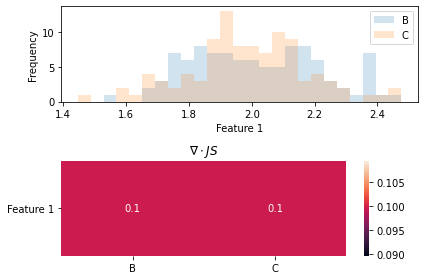

In [293]:
# In truth, they are sampled identically
bins = 25

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
axes[0].hist(B, label='B', bins=bins, range=ranges, alpha=0.2)
axes[0].hist(C, label='C', bins=bins, range=ranges, alpha=0.2)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
fig.patch.set_facecolor('white')

jsc_no_outlier = JSC(n=1, feature_names=['Feature 1'], js_bins=bins)
_ = jsc_no_outlier.fit(X, y)
jsc_no_outlier.visualize_grid(axes[1])

plt.tight_layout()
plt.savefig('js_example12.png', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
# There is no real way to choose the bin width - too fine you always get JS --> 0, too coarse you always get 
# JS --> 0.  If you instead choose the number of bins, outliers are relatively easy to identify and remove.
# Therein, a reasonably bin number is easier to intuite - for standardized data I find bins ~ 25 is good.